In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

%matplotlib inline

In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
df_raw.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [4]:
df_raw.nunique()

10k           2766
name         31915
division      6979
25k           6570
gender           2
age             64
official     11030
bib          31984
genderdiv    17575
ctz             84
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

### Preprocessing

In [5]:
#drop irrelevant/non numeric columns
df = df_raw.copy()
df = df.drop(['name','bib','ctz','state','country','city'], axis=1)

#hyphens indicate NaN in split time columns and making objects
temp_list = ['10k', '25k', '35k', '30k', '5k', '20k', '40k', 'half']
for item in temp_list:
    df[item] = df[item].replace('-', 'NaN').astype(float)
    df[item].fillna(df[item].mean(), inplace=True)
    
#convert gender from object to float by converting to boolean, M=0 F=1
df['gender'] = df['gender'].apply(lambda x: 0 if x is 'M' else 1)

#inspect results, should have no objects, gender should be all 0 or 1
print(df.info())
print(df['gender'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 15 columns):
10k          31984 non-null float64
division     31984 non-null int64
25k          31984 non-null float64
gender       31984 non-null int64
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
30k          31984 non-null float64
5k           31984 non-null float64
half         31984 non-null float64
20k          31984 non-null float64
40k          31984 non-null float64
dtypes: float64(10), int64(5)
memory usage: 3.7 MB
None
0    17617
1    14367
Name: gender, dtype: int64


### Prepare for clustering

In [6]:
#assign a variable for data to leave df alone and for readability
X = df.copy()

#normalize, 2 feat PCA for graphs
X_norm = normalize(X)
X_pca = PCA(2).fit_transform(X_norm)

In [7]:
#create subsets for cross validation
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42
    )
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

#make sure it worked
print('should all be True:',
      len(X1) == len(X_pca1),
      len(X2) == len(X_pca2),
      len(X3) == len(X_pca3),
      len(X4) == len(X_pca4))

should all be True: True True True True


## k-means

In [8]:
#set df for predictions
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    #cluster predictions for clusters 2 to 6.
    for nclust in range(2, 7):
        model = KMeans(n_clusters=nclust, random_state=42)
        pred = model.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        #silhouette scores
        labels = model.labels_
        sil_score = metrics.silhouette_score(data[0],
                                             labels,
                                             metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score},
            ignore_index=True)

In [9]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
7,clust4_sample1,0.495658
2,clust4_sample0,0.493525
12,clust4_sample2,0.493257
17,clust4_sample3,0.491322
6,clust3_sample1,0.478796
16,clust3_sample3,0.476207
11,clust3_sample2,0.476144
1,clust3_sample0,0.474392
0,clust2_sample0,0.459806
8,clust5_sample1,0.457907


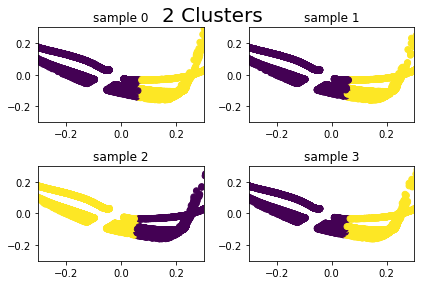

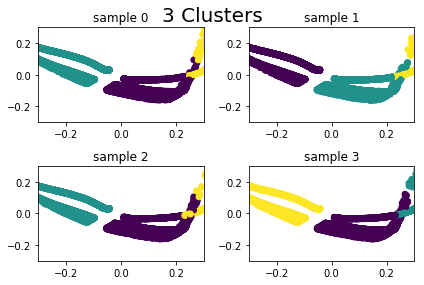

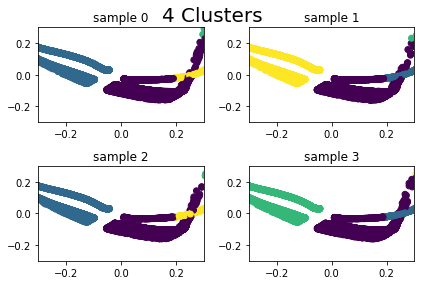

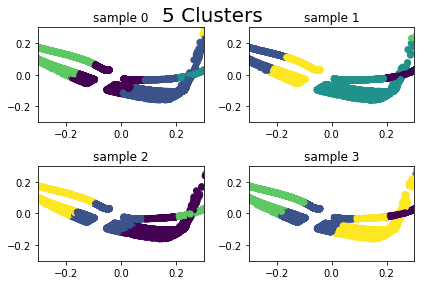

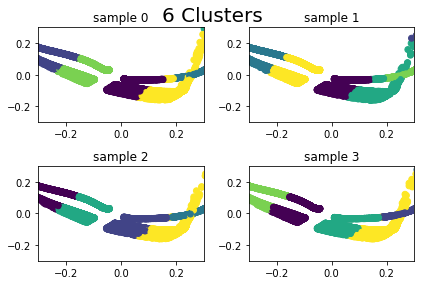

In [10]:
#plot solutions
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

## mean-shift

In [13]:
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score', 'quantile'])

for counter, data in enumerate([X1, X2, X3, X4]):
    #iterate through possible quantiles for cluster solutions
    for quantile in [0.1, 0.2, 0.3, 0.4, 0.5]:
        bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
        model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = model.fit_predict(data)
        labels = model.labels_
        nclust = len(np.unique(labels))
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        sil_score = metrics.silhouette_score(data, labels, metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score,
            'quantile':quantile},
            ignore_index=True)

In [14]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score,quantile
9,clust2_sample1,0.738678,0.5
14,clust4_sample2,0.570846,0.5
1,clust4_sample0,0.530170,0.2
6,clust4_sample1,0.525162,0.2
11,clust4_sample2,0.518161,0.2
2,clust4_sample0,0.515556,0.3
8,clust4_sample1,0.513436,0.4
3,clust4_sample0,0.505169,0.4
17,clust5_sample3,0.500969,0.3
4,clust3_sample0,0.499935,0.5


## Spectral Clustering

In [15]:
#set df for predictions
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    #cluster predictions for clusters 2 to 6.
    for nclust in range(2, 7):
        model = SpectralClustering(n_clusters=nclust)
        pred = model.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        #silhouette scores
        labels = model.labels_
        sil_score = metrics.silhouette_score(data[0],
                                             labels,
                                             metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score},
            ignore_index=True)

In [16]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
7,clust4_sample1,0.493188
2,clust4_sample0,0.492336
12,clust4_sample2,0.490365
17,clust4_sample3,0.488481
6,clust3_sample1,0.476786
16,clust3_sample3,0.474210
11,clust3_sample2,0.473528
1,clust3_sample0,0.471070
10,clust2_sample2,0.444203
5,clust2_sample1,0.442779


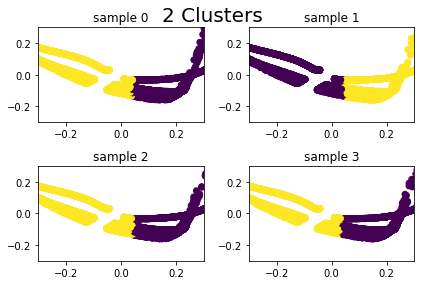

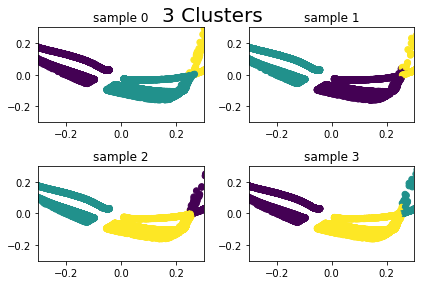

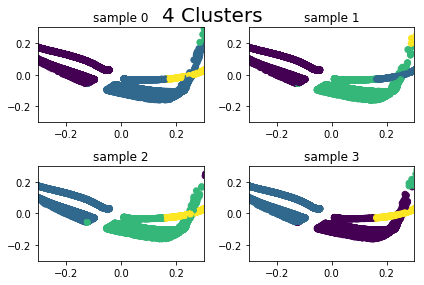

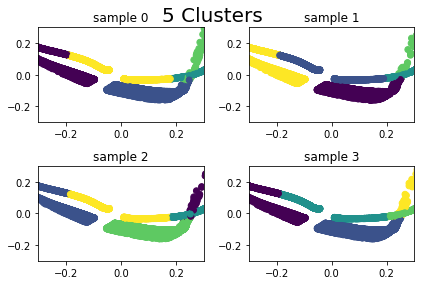

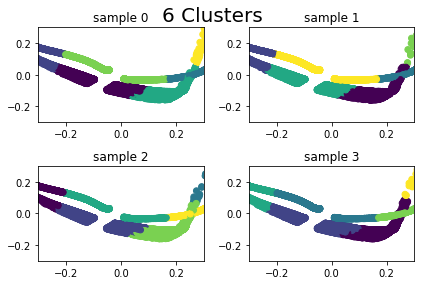

In [17]:
#plot solutions
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

## Affinity propagation

Need to take a sample of all data, runs very slow

In [21]:
af_data = X.sample(frac=0.25)

af_norm = normalize(af_data)
af_pca = PCA(2).fit_transform(af_norm)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    af_norm,
    af_pca,
    test_size=0.5,
    random_state=42
    )
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

#make sure it worked
print('should all be True:',
      len(X1) == len(X_pca1),
      len(X2) == len(X_pca2),
      len(X3) == len(X_pca3),
      len(X4) == len(X_pca4))

should all be True: True True True True


In [22]:
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([X1, X2, X3, X4]):
    #fit model
    model = AffinityPropagation().fit(data)
    cluster_centers_indices = model.cluster_centers_indices_
    n_clusters = len(cluster_centers_indices)
    labels = model.labels_
    #silhouette scores
    sil_score = metrics.silhouette_score(data, labels, metric='euclidean')
    sil_scores = sil_scores.append({
        'cluster':'clust' + str(n_clusters) + '_sample' + str(counter), 
        'sil_score':sil_score},
        ignore_index=True)

In [23]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
2,clust679_sample2,0.206286
1,clust819_sample1,0.194970
0,clust836_sample0,0.191564
3,clust1123_sample3,0.141705


## Conclusion

- 4 cluster solutions provide the most stable results measured by silhouette score
- Mean-shift produced the highest scores but was also not very consistent
- K-means and spectral clustering solutions were slightly lower than mean-shift, but also more consistent
- Affinity propagation takes very long to run and generates an exceedingly large amount of clusters (overfitting) with low silhouette scores